In [1]:
# CÉLULA 0 – Instalar dependências automaticamente com uv (roda só uma vez)
import subprocess
import sys
from pathlib import Path

print("Instalando/atualizando dependências com uv...")

# 1. Instala o uv se ainda não existir
try:
    subprocess.run(["uv", "--version"], check=True, capture_output=True)
    print("uv já está instalado")
except (subprocess.CalledProcessError, FileNotFoundError):
    print("uv não encontrado → instalando agora...")
    subprocess.run([sys.executable, "-m", "pip", "install", "uv"], check=True)

# 2. Se houver pyproject.toml na pasta atual → sincroniza tudo com uv
if Path("pyproject.toml").exists():
    print("pyproject.toml encontrado → instalando todas as dependências...")
    result = subprocess.run(["uv", "sync", "--frozen"], capture_output=True, text=True)
    if result.returncode == 0:
        print("Todas as dependências instaladas/atualizadas com sucesso!")
    else:
        print("Erro no uv sync:", result.stderr)
else:
    print("AVISO: pyproject.toml não encontrado – pula instalação automática")

# 3. (Opcional) Mostra as versões instaladas
try:
    subprocess.run(["uv", "pip", "list", "--format=freeze"], check=True)
except:
    pass

Instalando/atualizando dependências com uv...
uv já está instalado
pyproject.toml encontrado → instalando todas as dependências...
Todas as dependências instaladas/atualizadas com sucesso!


In [2]:
# Célula 1 – Imports e estilo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from IPython.display import display, Markdown
import pickle
import os

plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")
%matplotlib inline

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [3]:
# Célula 2 – Carregar e preparar dados

# Queremos apenas os vinhos de países da União Europeia
eu_countries = ['Portugal','France','Italy','Spain','Germany','Austria','Greece','Hungary',
                'Romania','Bulgaria','Croatia','Slovenia','Slovakia','Czech Republic','Poland',
                'Cyprus','Malta','Belgium','Netherlands','Luxembourg','Ireland','Denmark',
                'Sweden','Finland','Estonia','Latvia','Lithuania']

df = pd.read_csv('./data/winemag-data-130k-v2.csv')
df_eu = df[df['country'].isin(eu_countries)].copy()

# Limpeza preço
df_eu['price'] = df_eu.groupby('country')['price'].transform(lambda x: x.fillna(x.median()))
df_eu['price'].fillna(df_eu['price'].median(), inplace=True)
df_eu = df_eu[df_eu['price'] > 0].copy()

# Qualidade/preço
df_eu['points_per_euro'] = df_eu['points'] / df_eu['price']

display(Markdown(f"**Vinhos da UE analisados: {len(df_eu):,}**"))
df_eu.head()

**Vinhos da UE analisados: 60,542**

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,points_per_euro
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,28.0,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,3.107143
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,5.800000
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,5.800000
6,6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,5.437500
7,7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach,3.625000


In [4]:
# Célula 3 – Métricas principais
ranking = df_eu.groupby('country')['points'].mean().round(2)
top_pais = ranking.idxmax()
top_pts  = ranking.max()
melhor_qp = df_eu.groupby('country')['points_per_euro'].mean().idxmax()

display(Markdown(f"""
### Métricas Principais
- **Melhor qualidade média**: {top_pais} → **{top_pts} pontos**  
- **Melhor custo-benefício**: {melhor_qp}  
- **Total de vinhos UE**: {len(df_eu):,}
"""))


### Métricas Principais
- **Melhor qualidade média**: Austria → **90.1 pontos**  
- **Melhor custo-benefício**: Romania  
- **Total de vinhos UE**: 60,542


In [5]:
# Célula 4 – Mapa Choropleth 
points_by_country = ranking.reset_index()

fig = px.choropleth(points_by_country,
                    locations="country", locationmode="country names",
                    color="points", hover_name="country",
                    color_continuous_scale="Reds", range_color=(86,94),
                    title="Pontuação Média por País da UE")

# Mostrar contexto geográfico (terras, oceano, costas) e limitar ao continente
# reduzir projection_scale para não fazer zoom excessivo; usar ranges fixos para manter contexto
fig.update_geos(scope="europe",
                lataxis_range=[34,74], lonaxis_range=[-30,45],
                center=dict(lat=54, lon=15),
                projection_scale=1.1,  # valor pequeno para evitar zoom excessivo
                showcountries=True, showcoastlines=True, showland=True, showocean=True,
                landcolor="rgb(240,240,240)", oceancolor="rgb(210,230,255)")

fig.update_layout(height=600, margin={"r":0,"t":40,"l":0,"b":0})
fig

C:\Users\mprg2\AppData\Local\Temp\ipykernel_12472\886687203.py:4: DeprecationWarning: The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.
  fig = px.choropleth(points_by_country,


In [6]:
# Célula 5 – Top 10 vinhos da UE

top10 = df_eu.nlargest(10, 'points')[['title','country','winery','variety','points','price','province']]
top10.index = range(1,11)
top10.style.format({"price": "€{:.0f}", "points": "{:.0f} pts"})

,title,country,winery,variety,points,price,province
1,Avignonesi 1995 Occhio di Pernice (Vin Santo di Montepulciano),Italy,Avignonesi,Prugnolo Gentile,100 pts,€210,Tuscany
2,Krug 2002 Brut (Champagne),France,Krug,Champagne Blend,100 pts,€259,Champagne
3,Tenuta dell'Ornellaia 2007 Masseto Merlot (Toscana),Italy,Tenuta dell'Ornellaia,Merlot,100 pts,€460,Tuscany
4,Casa Ferreirinha 2008 Barca-Velha Red (Douro),Portugal,Casa Ferreirinha,Portuguese Red,100 pts,€450,Douro
5,Biondi Santi 2010 Riserva (Brunello di Montalcino),Italy,Biondi Santi,Sangiovese,100 pts,€550,Tuscany
6,Château Léoville Barton 2010 Saint-Julien,France,Château Léoville Barton,Bordeaux-style Red Blend,100 pts,€150,Bordeaux
7,Louis Roederer 2008 Cristal Vintage Brut (Champagne),France,Louis Roederer,Champagne Blend,100 pts,€250,Champagne
8,Salon 2006 Le Mesnil Blanc de Blancs Brut Chardonnay (Champagne),France,Salon,Chardonnay,100 pts,€617,Champagne
9,Château Lafite Rothschild 2010 Pauillac,France,Château Lafite Rothschild,Bordeaux-style Red Blend,100 pts,€1500,Bordeaux
10,Casanova di Neri 2007 Cerretalto (Brunello di Montalcino),Italy,Casanova di Neri,Sangiovese Grosso,100 pts,€270,Tuscany


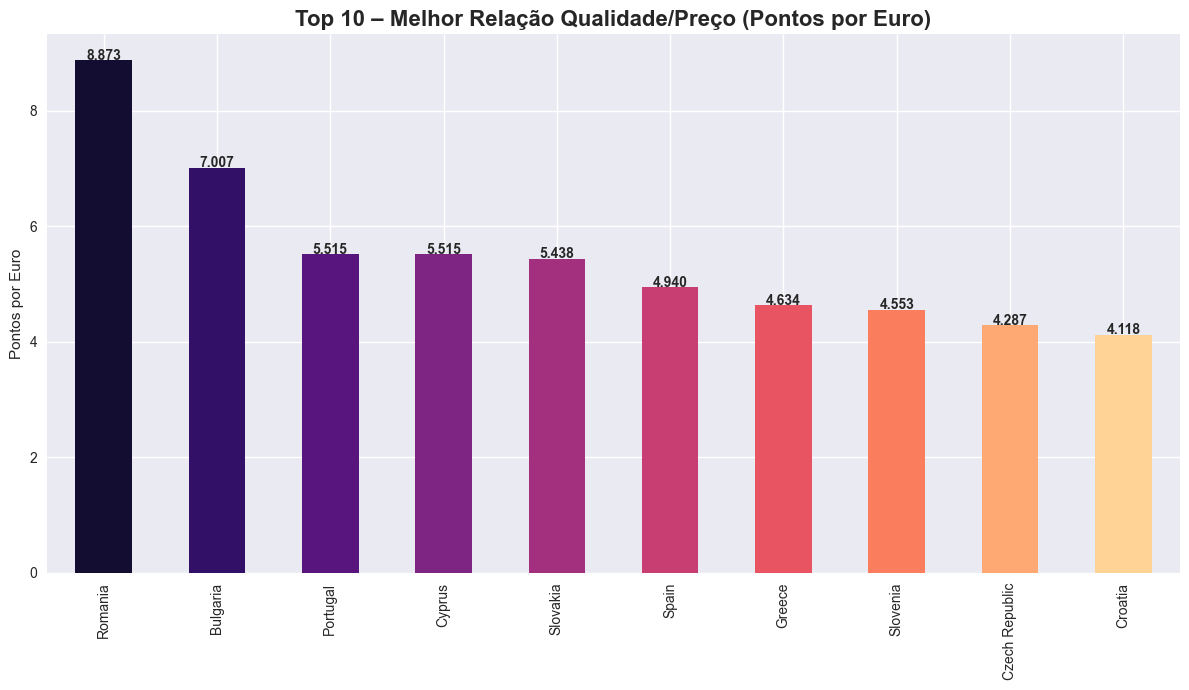

In [7]:
#Célula 6 – Top 10 relação qualidade/preço da UE

quality_price = df_eu.groupby('country')['points_per_euro'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,7))
ax = quality_price.head(10).plot(kind='bar', color=sns.color_palette("magma", 10))
plt.title("Top 10 – Melhor Relação Qualidade/Preço (Pontos por Euro)", fontsize=16, fontweight='bold')
plt.ylabel("Pontos por Euro")
plt.xlabel("")
for i, v in enumerate(quality_price.head(10)):
    ax.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')
plt.tight_layout()
# captura a figura antes de mostrar
fig_qp = ax.get_figure()
plt.show()

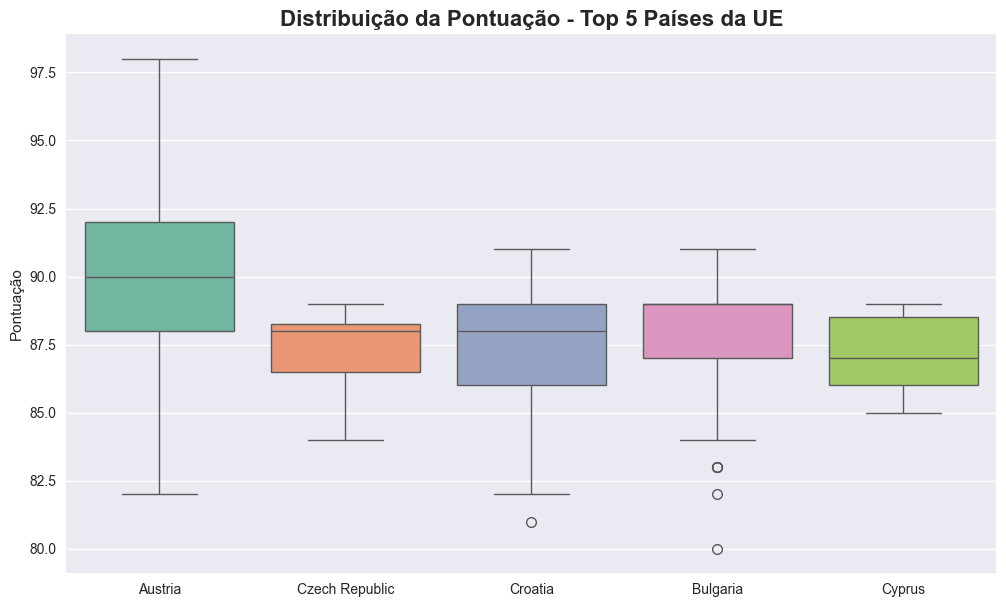

In [8]:
# Célula 7 – Boxplot dos 5 países com melhor pontuação média

top5_countries = ranking.head(5).index.tolist()

plt.figure(figsize=(12,7))
ax = sns.boxplot(
    data=df_eu[df_eu['country'].isin(top5_countries)],
    x='country', y='points',
    hue='country', palette='Set2', dodge=False
)
if ax.get_legend() is not None:
    ax.legend_.remove()
plt.title('Distribuição da Pontuação - Top 5 Países da UE', fontsize=16, fontweight='bold')
plt.ylabel('Pontuação')
plt.xlabel('')
fig_box = plt.gcf()
plt.show()

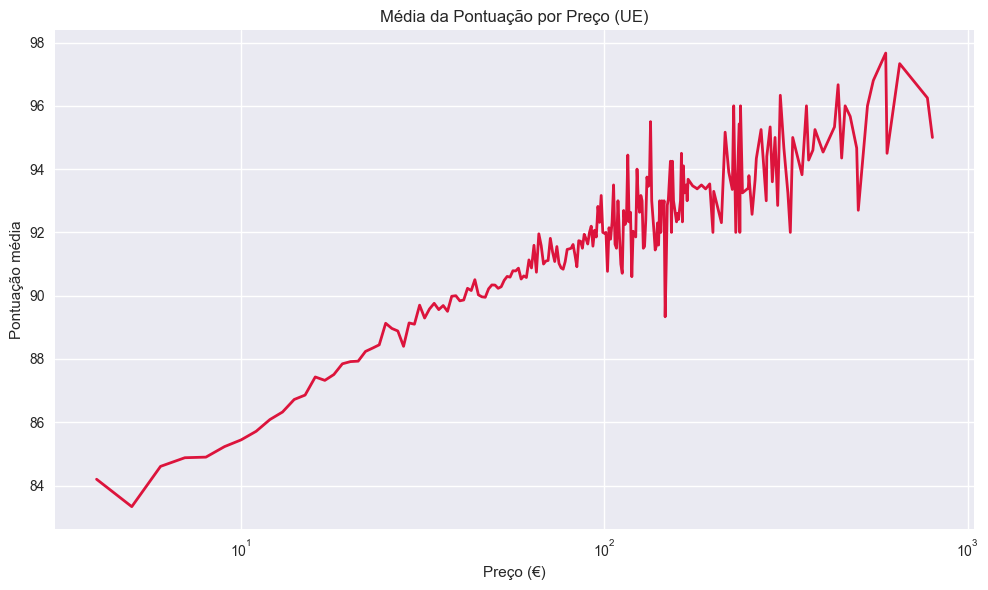

In [9]:
# Célula 8 – Relação preço vs pontuação (linha com média por preço)

# calcula média e conta por preço; filtra preços com poucas observações
points_by_price = df_eu.groupby('price')['points'].agg(mean='mean', count='count').reset_index()
points_by_price = points_by_price[points_by_price['count'] >= 3].sort_values('price')

plt.figure(figsize=(10,6))
sns.lineplot(data=points_by_price, x='price', y='mean', color='crimson', lw=2)
plt.xscale('log')  # opcional: mantém escala log para preços
plt.xlabel('Preço (€)')
plt.ylabel('Pontuação média')
plt.title('Média da Pontuação por Preço (UE)')
plt.tight_layout()
fig_price = plt.gcf()
plt.show()

In [10]:
# Célula 9 – Mapa com marcadores proporcionais (tamanhos menores e normalizados)
coordinates = {
    'Portugal': [39.5, -8.2], 'Spain': [40.4, -3.7], 'France': [46.2, 2.2],
    'Italy': [42.5, 12.1], 'Germany': [51.1, 10.4], 'Austria': [47.5, 13.2],
    'Hungary': [47.1, 19.5], 'Romania': [45.9, 24.9], 'Greece': [39.0, 21.8],
    'Bulgaria': [42.7, 25.4], 'Croatia': [45.1, 15.2], 'Slovenia': [46.1, 14.8],
    'Belgium': [50.5, 4.0], 'Netherlands': [52.1, 5.3], 'Poland': [52.1, 19.2]
}

# cria o mapa base (aqui sem mostrar / salvar ainda)
europe_map = folium.Map(location=[54, 15], zoom_start=4, tiles='CartoDB positron')

# parâmetros de tamanho (ajusta aqui se quiseres ainda mais pequeno/grande)
min_radius = 3
max_radius = 10

min_pts = ranking.min()
max_pts = ranking.max()

for country, coord in coordinates.items():
    if country in ranking.index:
        pts = float(ranking[country])
        # normaliza pts para o intervalo [min_radius, max_radius]
        if max_pts > min_pts:
            radius = min_radius + (pts - min_pts) / (max_pts - min_pts) * (max_radius - min_radius)
        else:
            radius = (min_radius + max_radius) / 2
        radius = max(2, round(radius, 1))  # garante um mínimo visível

        folium.CircleMarker(
            location=coord,
            radius=radius,
            popup=f"<b>{country}</b><br>Pontuação média: {pts}",
            tooltip=f"{country}: {pts} pts",
            color='crimson',
            fill=True,
            fill_color='crimson',
            fill_opacity=0.7
        ).add_to(europe_map)

# salva e mostra apenas o mapa final com marcadores
europe_map.save('folium_map.html')
folium_html = 'folium_map.html'
display(europe_map)
# ...existing code...

In [11]:
# Célula 10: Criar e guardar todos os objetos para o Streamlit usar
fig_mapa_html = None
if 'fig' in globals() and fig is not None:
    try:
        fig.write_html('fig_mapa.html')
        fig_mapa_html = 'fig_mapa.html'
    except Exception as e:
        print("Aviso Plotly:", e)

# Guarda figuras matplotlib como PNG
fig_qp_path = 'fig_qp.png'    if 'fig_qp'    in globals() and fig_qp    is not None else None
fig_box_path = 'fig_box.png'   if 'fig_box'   in globals() and fig_box   is not None else None
fig_price_path = 'fig_price.png' if 'fig_price' in globals() and fig_price is not None else None

if fig_qp_path and fig_qp is not None:
    fig_qp.savefig(fig_qp_path, bbox_inches='tight', dpi=180)
if fig_box_path and fig_box is not None:
    fig_box.savefig(fig_box_path, bbox_inches='tight', dpi=180)
if fig_price_path and fig_price is not None:
    fig_price.savefig(fig_price_path, bbox_inches='tight', dpi=180)

# Folium
folium_path = 'folium_map.html' if os.path.exists('folium_map.html') else None

# DICIONÁRIO PRINCIPAL – tudo o que o Streamlit vai usar
dados_para_app = {
    'df_eu': df_eu,
    'ranking': ranking,
    'top_pais': top_pais,
    'top_pts': top_pts,
    'melhor_qp': melhor_qp,
    'fig_mapa_html': fig_mapa_html,
    'fig_qp_path': fig_qp_path,
    'fig_box_path': fig_box_path,
    'fig_price_path': fig_price_path,
    'folium_html': folium_path,
    'coordinates': coordinates,
}

# Vamos deixar espaço para a célula da felicidade adicionar mais coisas depois
with open('dados_notebook.pkl', 'wb') as f:
    pickle.dump(dados_para_app, f)

print("Tudo guardado em dados_notebook.pkl – Streamlit pronto!")
print(f"   → {len(dados_para_app)} objetos exportados")

Tudo guardado em dados_notebook.pkl – Streamlit pronto!
   → 11 objetos exportados


## Felicidade Nacional × Qualidade do Vinho (2024)


**Correlação encontrada: 0.486**  
**Países analisados: 14 (com dados de vinhos e felicidade)**  
*(valores positivos = países mais felizes tendem a ter melhores vinhos)*


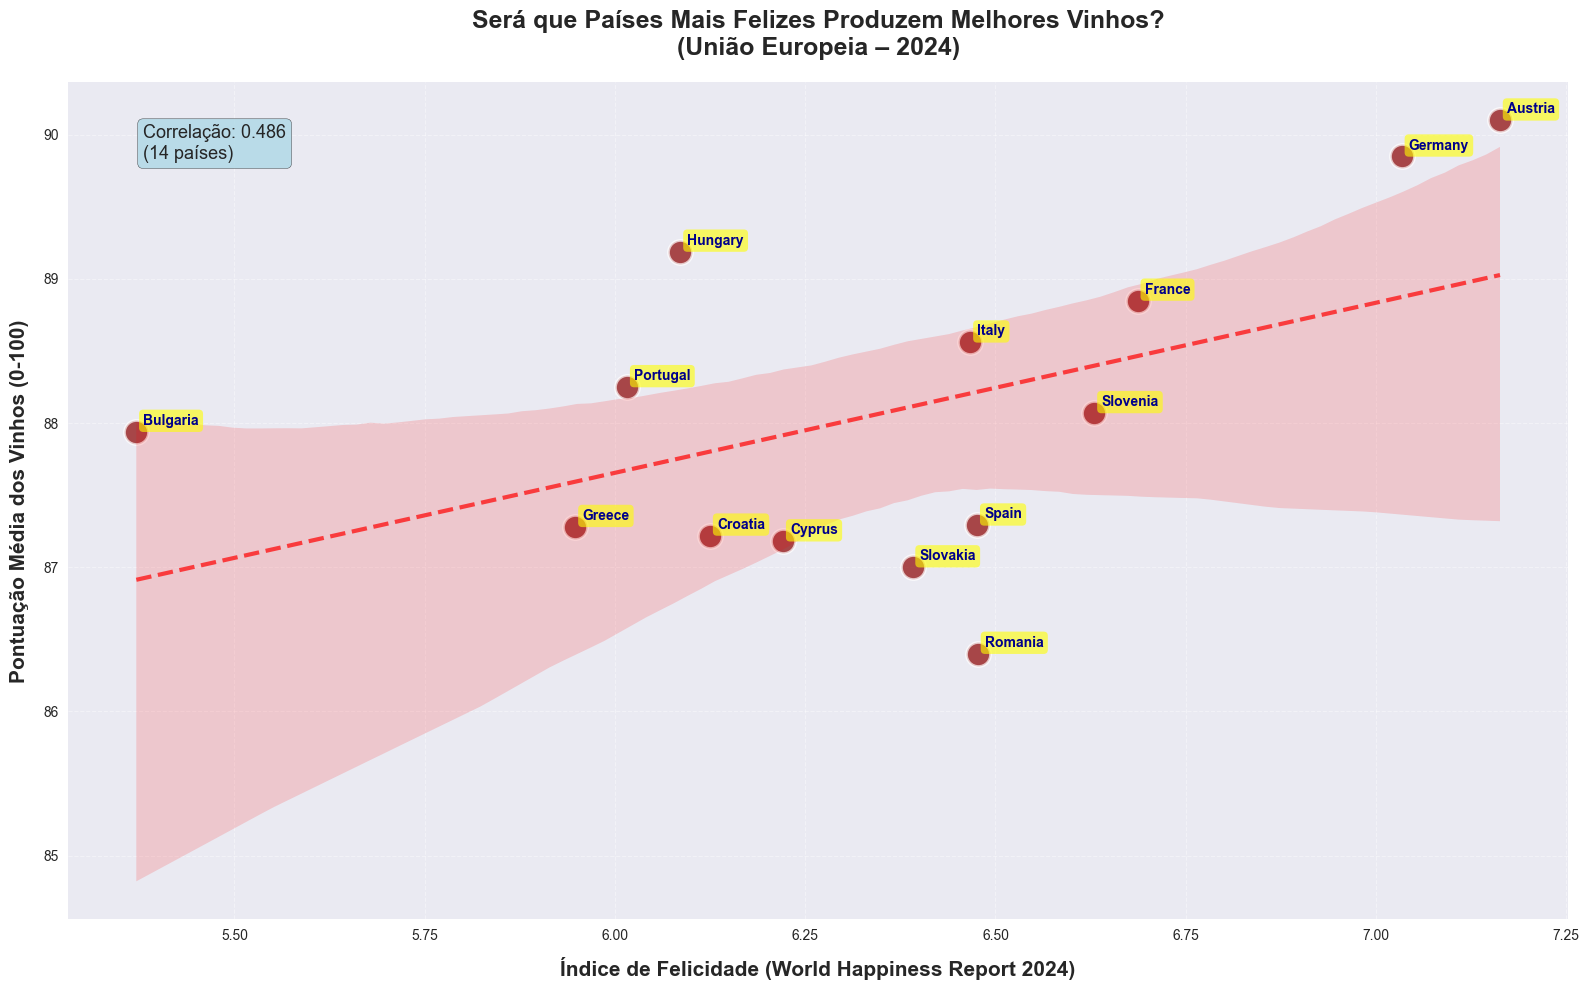

**✅ Análise de felicidade adicionada ao Streamlit!**

In [12]:
# Célula 11: Felicidade vs Qualidade do Vinho (IDEIA DO STOR!)
from IPython.display import display, Markdown
import seaborn as sns
import matplotlib.pyplot as plt

display(Markdown("## Felicidade Nacional × Qualidade do Vinho (2024)"))

# Carrega o dataset de felicidade
happiness = pd.read_csv('./data/happiness.csv')

# Normaliza os nomes dos países
happiness['country'] = happiness['Country'].str.strip()

# Pega apenas países com vinhos no ranking
paises_com_vinhos = ranking.index.tolist()

# Filtra happiness para países com vinhos
happiness_filtrado = happiness[happiness['country'].isin(paises_com_vinhos)].copy()

# Corrige formato do score (vírgula → ponto)
happiness_filtrado['score'] = happiness_filtrado['Happiness score'].str.replace(',', '.').astype(float)

# Merge: só países com vinhos E dados de felicidade
df_merged = pd.DataFrame({'country': ranking.index, 'points': ranking.values})
df_final = df_merged.merge(happiness_filtrado[['country', 'score']], on='country', how='inner')

# Correlação
correlacao = df_final['points'].corr(df_final['score']).round(3)

display(Markdown(f"""
**Correlação encontrada: {correlacao}**  
**Países analisados: {len(df_final)} (com dados de vinhos e felicidade)**  
*(valores positivos = países mais felizes tendem a ter melhores vinhos)*
"""))

# Gráfico MELHORADO - todos os países identificados
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(
    data=df_final, 
    x='score', 
    y='points',
    s=300,  # tamanho fixo para todas as bolinhas
    color='darkred', 
    alpha=0.7,
    edgecolor='white',
    linewidth=2
)

# IDENTIFICA TODOS OS PAÍSES (não só alguns)
for _, row in df_final.iterrows():
    ax.annotate(
        row['country'],
        xy=(row['score'], row['points']),
        xytext=(5, 5),  # offset do texto
        textcoords='offset points',
        fontsize=10,
        fontweight='bold',
        color='darkblue',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.6, edgecolor='none')
    )

# Linha de tendência
sns.regplot(
    data=df_final, 
    x='score', 
    y='points', 
    scatter=False, 
    color='red', 
    line_kws={'lw': 3, 'linestyle': '--', 'alpha': 0.7}
)

# EIXOS BEM IDENTIFICADOS
plt.xlabel('Índice de Felicidade (World Happiness Report 2024)', 
           fontsize=15, fontweight='bold', labelpad=10)
plt.ylabel('Pontuação Média dos Vinhos (0-100)', 
           fontsize=15, fontweight='bold', labelpad=10)

plt.title('Será que Países Mais Felizes Produzem Melhores Vinhos?\n(União Europeia – 2024)', 
          fontsize=18, fontweight='bold', pad=20)

# Grid mais visível
plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)

# Anotação da correlação no gráfico
ax.text(0.05, 0.95, f'Correlação: {correlacao}\n({len(df_final)} países)', 
        transform=ax.transAxes, fontsize=13, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()

# SALVAR FIGURA
fig_happiness = plt.gcf()
fig_happiness.savefig('fig_happiness.png', dpi=200, bbox_inches='tight')
plt.show()

# ADICIONAR ao dicionário pickle
dados_para_app['df_final_happiness'] = df_final
dados_para_app['correlacao_felicidade'] = correlacao
dados_para_app['fig_happiness_path'] = 'fig_happiness.png'

# Atualiza o pickle
with open('dados_notebook.pkl', 'wb') as f:
    pickle.dump(dados_para_app, f)

display(Markdown("**✅ Análise de felicidade adicionada ao Streamlit!**"))

In [ ]:
!streamlit run app.py
# No caso de lhe pedir o email, basta rodar no terminal manualmente a primeira vez. Depois esta célula funcionará sempre.\